In [14]:
import os
import nest_asyncio

import gym
from gym.spaces import Box, Discrete

from stable_baselines3 import PPO, DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy



import numpy as np
import matplotlib.pyplot as plt
import seaborn

from poke_env.player.env_player import Gen8EnvSinglePlayer
from poke_env.player.random_player import RandomPlayer

nest_asyncio.apply()

In [2]:
class SimpleRLPlayer(Gen8EnvSinglePlayer):

    observation_space = Box(low=-10, high=10, shape=(10,))
    action_space = Discrete(22)

    def getThisPlayer(self):
        return self

    def __init__(self, *args, **kwargs):
        Gen8EnvSinglePlayer.__init__(self)

    def embed_battle(self, battle):
        # -1 indicates that the move does not have a base power
        # or is not available
        moves_base_power = -np.ones(4)
        moves_dmg_multiplier = np.ones(4)
        for i, move in enumerate(battle.available_moves):
            moves_base_power[i] = (
                move.base_power / 100
            )  # Simple rescaling to facilitate learning
            if move.type:
                moves_dmg_multiplier[i] = move.type.damage_multiplier(
                    battle.opponent_active_pokemon.type_1,
                    battle.opponent_active_pokemon.type_2,
                )

        # We count how many pokemons have not fainted in each team
        remaining_mon_team = (
            len([mon for mon in battle.team.values() if mon.fainted]) / 6
        )
        remaining_mon_opponent = (
            len([mon for mon in battle.opponent_team.values() if mon.fainted]) / 6
        )

        # Final vector with 10 components
        return np.concatenate(
            [
                moves_base_power,
                moves_dmg_multiplier,
                [remaining_mon_team, remaining_mon_opponent],
            ]
        )

    def compute_reward(self, battle) -> float:
        return self.reward_computing_helper(
            battle, fainted_value=2, hp_value=1, victory_value=30
        )

In [3]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              #TODO: Check if work for check_freq
              mean_reward = np.mean(y[-self.check_freq:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

In [4]:
envPlayer = SimpleRLPlayer()
opponent = RandomPlayer()

log_dir = "TrainedAgents/AgentLogs/PokeEnv_DQN"
os.makedirs(log_dir, exist_ok=True)

envPlayer = Monitor(envPlayer, log_dir)
model = DQN('MlpPolicy', envPlayer, gamma=0.5, verbose=1)


Using cpu device
Wrapping the env in a DummyVecEnv.


In [5]:
def ray_training_function(player):

    print ("Training...")
    rewardVisCallback = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir)
    model.learn(total_timesteps=10000, callback = rewardVisCallback)
    print("Training complete.")

In [6]:
def ray_evaluating_function(player):
    player.reset_battles()
    for _ in range(100):
        done = False
        obs = player.reset()
        while not done:
            action = model.predict(obs)[0]
            obs, _, done, _ = player.step(action)
            # print ("done:" + str(done))
    player.complete_current_battle()

    print(
        "DQN Evaluation: %d victories out of %d episodes"
        % (player.n_won_battles, 100)
    )

In [7]:
# Training
envPlayer.play_against(
    env_algorithm=ray_training_function,
    opponent=opponent,
)

envPlayer.play_against(
    env_algorithm=ray_evaluating_function,
    opponent=opponent,
)

model.save("TrainedAgents/AgentModels/DQN/vsRandom/DQNvsRandom")


|    total timesteps  | 4701     |
----------------------------------
Num timesteps: 4800
Best mean reward: 37.98 - Last mean reward per episode: -0.52
Num timesteps: 4900
Best mean reward: 37.98 - Last mean reward per episode: -0.91
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 59.2     |
|    ep_rew_mean      | -1.72    |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 84       |
|    fps              | 108      |
|    time_elapsed     | 46       |
|    total timesteps  | 4976     |
----------------------------------
Num timesteps: 5000
Best mean reward: 37.98 - Last mean reward per episode: -1.72
Num timesteps: 5100
Best mean reward: 37.98 - Last mean reward per episode: -1.64
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 58.9     |
|    ep_rew_mean      | -2.38    |
|    exploration rate | 0.05     |
| time/               |          |
|    e

In [8]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    print(x.shape, y.shape)
    y = moving_average(y, window=1)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed: PokeEnvPlayer DQN")
    plt.show()

(165,) (165,)


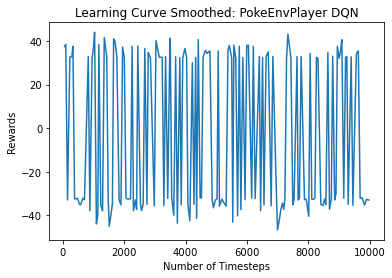

In [9]:
plot_results(log_dir)